# Native Language Accent [Hausa, Igbo, Yoruba] using KNN

## Module Imports

All necessary python libraries for dta collection, cleaning, analysis, modelling, and evaluation are imported

In [1]:
# General Utilities 
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10,6
import seaborn as sns

# Audio Preprocessng
from pydub import AudioSegment, effects
from pydub.silence import split_on_silence
import librosa

# Data Preprocessing and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,  confusion_matrix, classification_report, ConfusionMatrixDisplay

# machine Learning Models
from sklearn.neighbors import KNeighborsClassifier

# Audio Scraping
import yt_dlp
import os

# Model Deploying
import streamlit as st
import joblib

## DATA COLLECTION

In [2]:
def download_audio(accent, urls, output_dir='data'):
    accent_dir = os.path.join(output_dir, accent)
    os.makedirs(accent_dir, exist_ok=True)

    for i, url in enumerate(urls, 1):
        ydl_opts = {
            'format': 'bestaudio/best',
            'outtmpl': f'{accent_dir}/{accent}_{i:02d}.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
                'preferredquality': '192',
            }],
            'quiet': False
        }

        try:
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([url])
        except Exception as e:
            print(f"Failed to download {url}: {e}")


In [3]:
yoruba_urls = [
    'https://youtube.com/shorts/6yzqZBTZBqk?si=w8z3fJT0IEhXzLgv',
    'https://youtube.com/shorts/5Rl5ztTzP2Q?si=TiRvXpG_oKcBCRDJ',
    'https://youtube.com/shorts/uU_cyJWSioE?si=CUSZYG5GZt0w0wgI',
    'https://youtube.com/shorts/fFjUo03MxY8?si=0kJojIXytGxmSsGd',
    'https://youtube.com/shorts/BX4ci6uNzJ4?si=qkRMu6bMVWYJT5Wa',
    'https://youtube.com/shorts/5WiZ7pFvFxU?si=qoR2le2Y6qwllEaf',
    'https://youtube.com/shorts/SiklCRczQAE?si=oM6Q3ycPGL1LuwFC',
    'https://youtube.com/shorts/AGVPFUus-9A?si=xTV5U1F67hWqrPb6',
    'https://youtube.com/shorts/WInUCWS6jHk?si=ceR23Daym7S2197i',
    'https://youtube.com/shorts/YaLI4cr9JvA?si=XwtVxfSKrYJp-Viu'
]


igbo_urls = [
    'https://youtube.com/shorts/dyxGOUUu0Z8?si=qPnMKYCCjlkYMs5Y',
    'https://youtube.com/shorts/Bkjonk3ZEvM?si=Og0WlXhbZK0Abu0t',
    'https://youtube.com/shorts/RLONT5QST3E?si=99ZNkkejM5ldtbk9',
    'https://youtube.com/shorts/KbKmvFCfTHA?si=LTQXVgcg_M_IQSZs',
    'https://youtube.com/shorts/X6jPr2yZH4Q?si=CS2Wnk90atdTZ9wb',
    'https://youtube.com/shorts/N3pojzaIoDc?si=NNGWUiB1s20AL0Dw',
    'https://youtube.com/shorts/TZvZFuqsUTY?si=62t9tKnq81NENtoR',
    'https://youtube.com/shorts/ftsWToc0R2I?si=KI9lgINnoSyyBzoL',
    'https://youtube.com/shorts/WzCc2pT-39A?si=XgFCZaOYrOZ_RTyW',
    'https://youtube.com/shorts/4XukGIjntmA?si=2jWY21dKT82Z7CFX'
]

hausa_urls = [
     'https://youtube.com/shorts/Eq3QGlzFOYs?si=k24KE8x8kjHuuegS',
    'https://youtube.com/shorts/J5d3QdchiAQ?si=ZDNL_G7JrSgY-0gw',
    'https://youtube.com/shorts/JWzGK9EquZU?si=ArbIFLInoTGHhQ8P',
    'https://youtube.com/shorts/S9HXn1IpTDk?si=5cESbPGIqkgq6x1L',
    'https://youtube.com/shorts/pI6BR9GTBhI?si=5z1d48MmJg6c7yKZ',
    'https://youtube.com/shorts/y2DESH8XX4E?si=AwwJ2ySB_w6RHsYy',
    'https://youtube.com/shorts/xnwSjE2LbjQ?si=ASA5fUIRyDMWQyBv',
    'https://youtube.com/shorts/Ykei-PEHx5Q?si=kTWFDGs6g0pqUSrc',
    'https://youtube.com/shorts/4kC38W7KLd8?si=l2gOCq6HABJBslYM',
    'https://youtube.com/shorts/VZ_FQxNe9qE?si=4I2ZME1E3s1oSA1o'
]


In [4]:
folder_path = "data"

if os.path.exists(folder_path):
    print("Folder already exists. Skipping function.")
else:
    download_audio('yoruba', yoruba_urls)
    download_audio('igbo', igbo_urls)
    download_audio('hausa', hausa_urls)

Folder already exists. Skipping function.


In [5]:
def preprocess_audio(input_folder='data', output_folder='processed_data', target_duration_ms=20000):
    os.makedirs(output_folder, exist_ok=True)

    for accent in os.listdir(input_folder):
        accent_path = os.path.join(input_folder, accent)
        output_accent_path = os.path.join(output_folder, accent)
        os.makedirs(output_accent_path, exist_ok=True)

        for filename in os.listdir(accent_path):
            if filename.endswith(".mp3") or filename.endswith(".wav"):
                input_path = os.path.join(accent_path, filename)

                # Load and convert to WAV
                audio = AudioSegment.from_file(input_path)
                audio = audio.set_frame_rate(16000).set_channels(1)  # Mono, 16kHz

                # Normalize volume
                normalized_audio = effects.normalize(audio)

                # Trim silence
                trimmed_audio = split_on_silence(
                    normalized_audio,
                    min_silence_len=500,
                    silence_thresh=normalized_audio.dBFS - 16,
                    keep_silence=300,
                )
                if trimmed_audio:
                    trimmed_audio = sum(trimmed_audio)
                else:
                    trimmed_audio = normalized_audio  # fallback in case silence trimming returns nothing


                # Clip to fixed duration
                final_audio = trimmed_audio[:target_duration_ms]
                if len(final_audio) < target_duration_ms:
                    silence_padding = AudioSegment.silent(duration=target_duration_ms - len(final_audio))
                    final_audio += silence_padding

                # Save as WAV
                output_path = os.path.join(output_accent_path, filename.rsplit('.', 1)[0] + '.wav')
                final_audio.export(output_path, format='wav')

                print(f"Processed: {output_path}")

In [6]:
folder_path = "processed_data"

if os.path.exists(folder_path):
    print("Folder already exists. Skipping function.")
else:
    preprocess_audio(input_folder='data', output_folder='processed_data', target_duration_ms=20000)  # 20 seconds

Folder already exists. Skipping function.


In [7]:
def extract_features(data_dir='processed_data'):
    data = []

    for label in os.listdir(data_dir):  # Hausa, Igbo, Yoruba
        label_path = os.path.join(data_dir, label)

        for file in os.listdir(label_path):
            if file.endswith('.wav'):
                file_path = os.path.join(label_path, file)

                try:
                    y, sr = librosa.load(file_path, sr=16000)

                    # --- MFCCs (Take mean of each of the 13 coefficients) ---
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                    mfccs_mean = mfccs.mean(axis=1)

                    # --- Pitch (using librosa.yin for fundamental frequency estimation) ---
                    f0 = librosa.yin(y, fmin=50, fmax=500)
                    pitch_mean = np.mean(f0)
                    pitch_std = np.std(f0)

                    # --- Zero-Crossing Rate ---
                    zcr = librosa.feature.zero_crossing_rate(y)
                    zcr_mean = np.mean(zcr)

                    # --- Spectral Contrast ---
                    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                    contrast_mean = contrast.mean(axis=1)

                    # --- Combine all features ---
                    feature_row = list(mfccs_mean) + [pitch_mean, pitch_std, zcr_mean] + list(contrast_mean) + [label]
                    data.append(feature_row)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    # --- Define column names ---
    columns = [f"mfcc_{i+1}" for i in range(13)] + ["pitch_mean", "pitch_std", "zcr"] + [f"contrast_{i+1}" for i in range(7)] + ["native_language"]

    df = pd.DataFrame(data, columns=columns)
    return df

In [8]:
file_path = "accent_features.csv"

if os.path.isfile(file_path):
    print("File already exists.")
    df = pd.read_csv("accent_features.csv")
else:
    df = extract_features(data_dir='processed_data')
    df.to_csv("accent_features.csv", index=False)
print(df.head())

File already exists.
      mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -222.61502  96.293100  -0.737145  -0.156933  -6.417421 -22.298155   
1 -196.85628  86.249405  19.348495  12.284666   1.776074  -7.566617   
2 -199.04907  30.968750   5.315518  27.871393 -22.036314 -13.232800   
3 -164.35736  86.307480  26.284286  -7.689272   3.319334  -3.707243   
4 -189.83142  78.165590  11.840050  20.451948   0.575667  -7.015273   

      mfcc_7     mfcc_8     mfcc_9    mfcc_10  ...   pitch_std       zcr  \
0 -16.730837  -9.945559 -10.579000 -10.798513  ...  100.511801  0.109426   
1  -8.314264  -5.185828  -4.914920  -4.193184  ...   75.885758  0.167622   
2   0.297162 -16.054720  -0.220790  -7.156560  ...  137.088454  0.216451   
3 -14.927552 -12.195855 -13.288478  -1.698122  ...   69.416309  0.151082   
4  -8.218061  -4.244741  -7.692166   3.096794  ...   85.559143  0.151551   

   contrast_1  contrast_2  contrast_3  contrast_4  contrast_5  contrast_6  \
0   21.967061   17

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mfcc_1           30 non-null     float64
 1   mfcc_2           30 non-null     float64
 2   mfcc_3           30 non-null     float64
 3   mfcc_4           30 non-null     float64
 4   mfcc_5           30 non-null     float64
 5   mfcc_6           30 non-null     float64
 6   mfcc_7           30 non-null     float64
 7   mfcc_8           30 non-null     float64
 8   mfcc_9           30 non-null     float64
 9   mfcc_10          30 non-null     float64
 10  mfcc_11          30 non-null     float64
 11  mfcc_12          30 non-null     float64
 12  mfcc_13          30 non-null     float64
 13  pitch_mean       30 non-null     float64
 14  pitch_std        30 non-null     float64
 15  zcr              30 non-null     float64
 16  contrast_1       30 non-null     float64
 17  contrast_2       3

In [10]:
# Resample each class individually to get 40 samples per class
dfs = []
for label in df['native_language'].unique():
    df_label = df[df['native_language'] == label]
    df_boot = resample(df_label, replace=True, n_samples=40, random_state=42)
    dfs.append(df_boot)

# Combine the resampled dataframes
df_augmented = pd.concat(dfs).reset_index(drop=True)

# Separate features and target
features = df_augmented.drop('native_language', axis=1).values
target = df_augmented['native_language'].values


In [11]:
df_augmented.to_csv('accent_features_bootstrapped.csv', index=False)

In [12]:
df = pd.read_csv('accent_features_bootstrapped.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mfcc_1           120 non-null    float64
 1   mfcc_2           120 non-null    float64
 2   mfcc_3           120 non-null    float64
 3   mfcc_4           120 non-null    float64
 4   mfcc_5           120 non-null    float64
 5   mfcc_6           120 non-null    float64
 6   mfcc_7           120 non-null    float64
 7   mfcc_8           120 non-null    float64
 8   mfcc_9           120 non-null    float64
 9   mfcc_10          120 non-null    float64
 10  mfcc_11          120 non-null    float64
 11  mfcc_12          120 non-null    float64
 12  mfcc_13          120 non-null    float64
 13  pitch_mean       120 non-null    float64
 14  pitch_std        120 non-null    float64
 15  zcr              120 non-null    float64
 16  contrast_1       120 non-null    float64
 17  contrast_2      

In [14]:
target = df['native_language']
features = df.drop(columns='native_language', axis=1)

In [15]:

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    stratify= target,
                                                    random_state=10)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
k_range = range(1, 21)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    scores.append(cv_scores.mean())

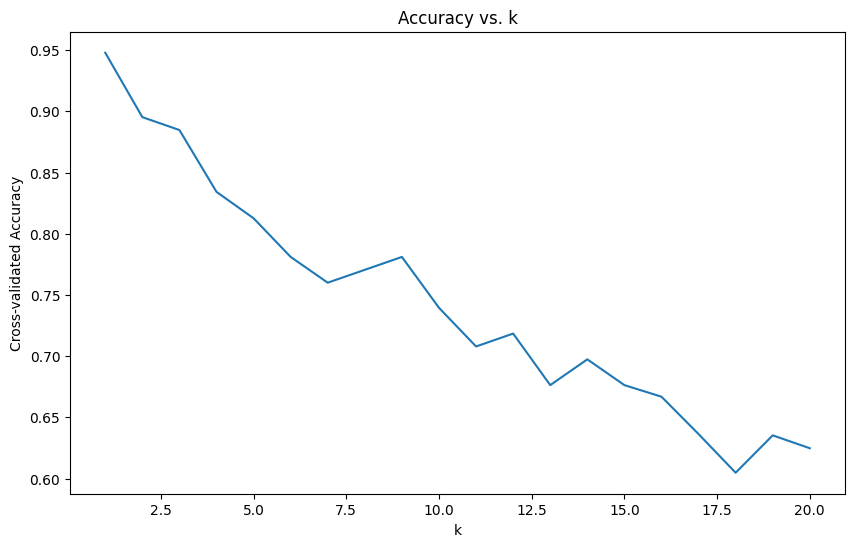

In [18]:
plt.plot(k_range, scores)
plt.xlabel('k')
plt.ylabel('Cross-validated Accuracy')
plt.title('Accuracy vs. k')
plt.show()

In [19]:
best_k = k_range[scores.index(max(scores))]
print("Best k:", best_k)

Best k: 1


In [20]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       hausa       1.00      1.00      1.00         8
        igbo       1.00      1.00      1.00         8
      yoruba       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



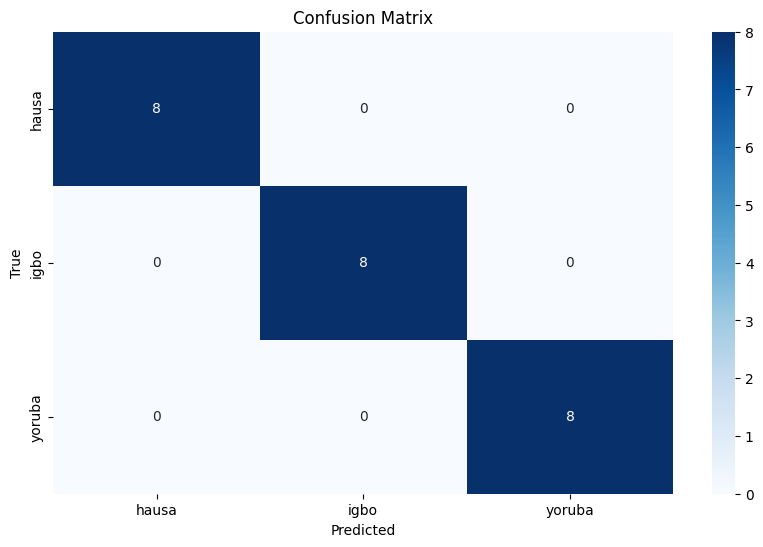

In [21]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

In [22]:
joblib.dump(model, 'knn_accent_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']